<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/Resnet_18_with_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 5/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 5/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 5/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 5/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 5/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 5/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 5/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((143120, 32, 32),
 (42967, 32, 32),
 (35780, 32, 32),
 (143120, 5),
 (42967, 5),
 (35780, 5))

In [5]:
X_train[0]

array([[0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275]], dtype=float32)

In [6]:
X_val[0]

array([[0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726]], dtype=float32)

In [7]:
Y_train[0]

array([1., 0., 0., 0., 0.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
model = ResNet18(5)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
560/559 [==============================] - ETA: 0s - loss: 1.2452 - accuracy: 0.4755 - f1_m: 0.3785 - precision_m: 0.6815 - recall_m: 0.2656

559/559 [==============================] - 87s 118ms/step - loss: 1.2452 - accuracy: 0.4755 - f1_m: 0.3785 - precision_m: 0.6815 - recall_m: 0.2656 - val_loss: 1.3548 - val_accuracy: 0.4472 - val_f1_m: 0.4106 - val_precision_m: 0.5385 - val_recall_m: 0.3321
Epoch 2/50
560/559 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.5809 - f1_m: 0.5204 - precision_m: 0.7473 - recall_m: 0.4007

559/559 [==============================] - 55s 99ms/step - loss: 0.9911 - accuracy: 0.5809 - f1_m: 0.5204 - precision_m: 0.7473 - recall_m: 0.4007 - val_loss: 1.1917 - val_accuracy: 0.5114 - val_f1_m: 0.4886 - val_precision_m: 0.6170 - val_recall_m: 0.4048
Epoch 3/50
560/559 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6287 - f1_m: 0.5870 - precision_m: 0.7628 - recall_m: 0.4779

559/559 [==============================] - 55s 98ms/step - loss: 0.8919 - accuracy: 0.6287 - f1_m: 0.5870 - precision_m: 0.7628 - recall_m: 0.4779 - val_loss: 1.0530 - val_accuracy: 0.5762 - val_f1_m: 0.5494 - val_precision_m: 0.6742 - val_recall_m: 0.4639
Epoch 4/50
560/559 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.6523 - f1_m: 0.6196 - precision_m: 0.7704 - recall_m: 0.5191

559/559 [==============================] - 55s 98ms/step - loss: 0.8423 - accuracy: 0.6523 - f1_m: 0.6196 - precision_m: 0.7704 - recall_m: 0.5191 - val_loss: 1.9978 - val_accuracy: 0.4112 - val_f1_m: 0.4041 - val_precision_m: 0.4404 - val_recall_m: 0.3735
Epoch 5/50
560/559 [==============================] - ETA: 0s - loss: 0.7965 - accuracy: 0.6721 - f1_m: 0.6463 - precision_m: 0.7821 - recall_m: 0.5512

559/559 [==============================] - 54s 97ms/step - loss: 0.7965 - accuracy: 0.6721 - f1_m: 0.6463 - precision_m: 0.7821 - recall_m: 0.5512 - val_loss: 0.8486 - val_accuracy: 0.6457 - val_f1_m: 0.6246 - val_precision_m: 0.7506 - val_recall_m: 0.5352
Epoch 6/50
560/559 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6926 - f1_m: 0.6730 - precision_m: 0.7918 - recall_m: 0.5856

559/559 [==============================] - 53s 94ms/step - loss: 0.7521 - accuracy: 0.6926 - f1_m: 0.6730 - precision_m: 0.7918 - recall_m: 0.5856 - val_loss: 0.7947 - val_accuracy: 0.6729 - val_f1_m: 0.6503 - val_precision_m: 0.7629 - val_recall_m: 0.5670
Epoch 7/50
560/559 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.7064 - f1_m: 0.6897 - precision_m: 0.7990 - recall_m: 0.6071

559/559 [==============================] - 52s 93ms/step - loss: 0.7207 - accuracy: 0.7064 - f1_m: 0.6897 - precision_m: 0.7990 - recall_m: 0.6071 - val_loss: 0.9180 - val_accuracy: 0.6422 - val_f1_m: 0.6333 - val_precision_m: 0.7119 - val_recall_m: 0.5706
Epoch 8/50
560/559 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7189 - f1_m: 0.7054 - precision_m: 0.8061 - recall_m: 0.6274

559/559 [==============================] - 51s 91ms/step - loss: 0.6916 - accuracy: 0.7189 - f1_m: 0.7054 - precision_m: 0.8061 - recall_m: 0.6274 - val_loss: 0.9355 - val_accuracy: 0.6369 - val_f1_m: 0.6236 - val_precision_m: 0.7098 - val_recall_m: 0.5562
Epoch 9/50
560/559 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7327 - f1_m: 0.7219 - precision_m: 0.8131 - recall_m: 0.6495

559/559 [==============================] - 54s 96ms/step - loss: 0.6603 - accuracy: 0.7327 - f1_m: 0.7219 - precision_m: 0.8131 - recall_m: 0.6495 - val_loss: 0.7370 - val_accuracy: 0.6996 - val_f1_m: 0.6909 - val_precision_m: 0.7797 - val_recall_m: 0.6205
Epoch 10/50
560/559 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.7471 - f1_m: 0.7375 - precision_m: 0.8215 - recall_m: 0.6694

559/559 [==============================] - 51s 92ms/step - loss: 0.6304 - accuracy: 0.7471 - f1_m: 0.7375 - precision_m: 0.8215 - recall_m: 0.6694 - val_loss: 0.7404 - val_accuracy: 0.7064 - val_f1_m: 0.6984 - val_precision_m: 0.7761 - val_recall_m: 0.6352
Epoch 11/50
560/559 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7574 - f1_m: 0.7482 - precision_m: 0.8283 - recall_m: 0.6826

559/559 [==============================] - 55s 99ms/step - loss: 0.6097 - accuracy: 0.7574 - f1_m: 0.7482 - precision_m: 0.8283 - recall_m: 0.6826 - val_loss: 0.7751 - val_accuracy: 0.6883 - val_f1_m: 0.6767 - val_precision_m: 0.7641 - val_recall_m: 0.6074
Epoch 12/50
560/559 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7694 - f1_m: 0.7624 - precision_m: 0.8349 - recall_m: 0.7017

559/559 [==============================] - 57s 102ms/step - loss: 0.5808 - accuracy: 0.7694 - f1_m: 0.7624 - precision_m: 0.8349 - recall_m: 0.7017 - val_loss: 0.6321 - val_accuracy: 0.7490 - val_f1_m: 0.7433 - val_precision_m: 0.8117 - val_recall_m: 0.6858
Epoch 13/50
560/559 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7745 - f1_m: 0.7675 - precision_m: 0.8367 - recall_m: 0.7092

559/559 [==============================] - 55s 97ms/step - loss: 0.5703 - accuracy: 0.7745 - f1_m: 0.7675 - precision_m: 0.8367 - recall_m: 0.7092 - val_loss: 0.7283 - val_accuracy: 0.7222 - val_f1_m: 0.7175 - val_precision_m: 0.7766 - val_recall_m: 0.6668
Epoch 14/50
560/559 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7867 - f1_m: 0.7813 - precision_m: 0.8450 - recall_m: 0.7268

559/559 [==============================] - 52s 94ms/step - loss: 0.5398 - accuracy: 0.7867 - f1_m: 0.7813 - precision_m: 0.8450 - recall_m: 0.7268 - val_loss: 0.6980 - val_accuracy: 0.7266 - val_f1_m: 0.7239 - val_precision_m: 0.7824 - val_recall_m: 0.6737
Epoch 15/50
560/559 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7968 - f1_m: 0.7929 - precision_m: 0.8505 - recall_m: 0.7428

559/559 [==============================] - 52s 94ms/step - loss: 0.5161 - accuracy: 0.7968 - f1_m: 0.7929 - precision_m: 0.8505 - recall_m: 0.7428 - val_loss: 0.6412 - val_accuracy: 0.7513 - val_f1_m: 0.7476 - val_precision_m: 0.8109 - val_recall_m: 0.6937
Epoch 16/50
560/559 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.8055 - f1_m: 0.8019 - precision_m: 0.8572 - recall_m: 0.7535

559/559 [==============================] - 50s 89ms/step - loss: 0.4963 - accuracy: 0.8055 - f1_m: 0.8019 - precision_m: 0.8572 - recall_m: 0.7535 - val_loss: 0.6145 - val_accuracy: 0.7590 - val_f1_m: 0.7555 - val_precision_m: 0.8112 - val_recall_m: 0.7071
Epoch 17/50
560/559 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8147 - f1_m: 0.8123 - precision_m: 0.8623 - recall_m: 0.7680

559/559 [==============================] - 50s 89ms/step - loss: 0.4719 - accuracy: 0.8147 - f1_m: 0.8123 - precision_m: 0.8623 - recall_m: 0.7680 - val_loss: 0.6029 - val_accuracy: 0.7664 - val_f1_m: 0.7643 - val_precision_m: 0.8142 - val_recall_m: 0.7203
Epoch 18/50
560/559 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8249 - f1_m: 0.8234 - precision_m: 0.8697 - recall_m: 0.7820

559/559 [==============================] - 50s 89ms/step - loss: 0.4507 - accuracy: 0.8249 - f1_m: 0.8234 - precision_m: 0.8697 - recall_m: 0.7820 - val_loss: 0.5643 - val_accuracy: 0.7809 - val_f1_m: 0.7790 - val_precision_m: 0.8283 - val_recall_m: 0.7354
Epoch 19/50
560/559 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8329 - f1_m: 0.8315 - precision_m: 0.8743 - recall_m: 0.7928

559/559 [==============================] - 49s 88ms/step - loss: 0.4327 - accuracy: 0.8329 - f1_m: 0.8315 - precision_m: 0.8743 - recall_m: 0.7928 - val_loss: 0.5881 - val_accuracy: 0.7807 - val_f1_m: 0.7798 - val_precision_m: 0.8181 - val_recall_m: 0.7450
Epoch 20/50
560/559 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8390 - f1_m: 0.8374 - precision_m: 0.8775 - recall_m: 0.8009

559/559 [==============================] - 49s 88ms/step - loss: 0.4179 - accuracy: 0.8390 - f1_m: 0.8374 - precision_m: 0.8775 - recall_m: 0.8009 - val_loss: 0.5438 - val_accuracy: 0.7936 - val_f1_m: 0.7934 - val_precision_m: 0.8361 - val_recall_m: 0.7550
Epoch 21/50
560/559 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8460 - f1_m: 0.8450 - precision_m: 0.8823 - recall_m: 0.8108

559/559 [==============================] - 49s 87ms/step - loss: 0.3995 - accuracy: 0.8460 - f1_m: 0.8450 - precision_m: 0.8823 - recall_m: 0.8108 - val_loss: 0.5701 - val_accuracy: 0.7871 - val_f1_m: 0.7880 - val_precision_m: 0.8268 - val_recall_m: 0.7527
Epoch 22/50
560/559 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8541 - f1_m: 0.8534 - precision_m: 0.8878 - recall_m: 0.8217

559/559 [==============================] - 48s 87ms/step - loss: 0.3804 - accuracy: 0.8541 - f1_m: 0.8534 - precision_m: 0.8878 - recall_m: 0.8217 - val_loss: 0.7243 - val_accuracy: 0.7407 - val_f1_m: 0.7394 - val_precision_m: 0.7788 - val_recall_m: 0.7040
Epoch 23/50
560/559 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8568 - f1_m: 0.8563 - precision_m: 0.8894 - recall_m: 0.8257

559/559 [==============================] - 51s 92ms/step - loss: 0.3738 - accuracy: 0.8568 - f1_m: 0.8563 - precision_m: 0.8894 - recall_m: 0.8257 - val_loss: 1.2419 - val_accuracy: 0.6993 - val_f1_m: 0.6966 - val_precision_m: 0.7234 - val_recall_m: 0.6718
Epoch 24/50
560/559 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.8576 - f1_m: 0.8567 - precision_m: 0.8900 - recall_m: 0.8260

559/559 [==============================] - 50s 89ms/step - loss: 0.3706 - accuracy: 0.8576 - f1_m: 0.8567 - precision_m: 0.8900 - recall_m: 0.8260 - val_loss: 0.6195 - val_accuracy: 0.7727 - val_f1_m: 0.7709 - val_precision_m: 0.8076 - val_recall_m: 0.7374
Epoch 25/50
560/559 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8700 - f1_m: 0.8697 - precision_m: 0.8978 - recall_m: 0.8434

559/559 [==============================] - 51s 91ms/step - loss: 0.3421 - accuracy: 0.8700 - f1_m: 0.8697 - precision_m: 0.8978 - recall_m: 0.8434 - val_loss: 0.5247 - val_accuracy: 0.8109 - val_f1_m: 0.8117 - val_precision_m: 0.8404 - val_recall_m: 0.7850
Epoch 26/50
560/559 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8777 - f1_m: 0.8779 - precision_m: 0.9037 - recall_m: 0.8536

559/559 [==============================] - 50s 89ms/step - loss: 0.3207 - accuracy: 0.8777 - f1_m: 0.8779 - precision_m: 0.9037 - recall_m: 0.8536 - val_loss: 0.4928 - val_accuracy: 0.8211 - val_f1_m: 0.8227 - val_precision_m: 0.8521 - val_recall_m: 0.7954
Epoch 27/50
560/559 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8797 - f1_m: 0.8794 - precision_m: 0.9039 - recall_m: 0.8564

559/559 [==============================] - 50s 89ms/step - loss: 0.3171 - accuracy: 0.8797 - f1_m: 0.8794 - precision_m: 0.9039 - recall_m: 0.8564 - val_loss: 0.6218 - val_accuracy: 0.7847 - val_f1_m: 0.7838 - val_precision_m: 0.8122 - val_recall_m: 0.7574
Epoch 28/50
560/559 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8856 - f1_m: 0.8858 - precision_m: 0.9086 - recall_m: 0.8642

559/559 [==============================] - 48s 86ms/step - loss: 0.3008 - accuracy: 0.8856 - f1_m: 0.8858 - precision_m: 0.9086 - recall_m: 0.8642 - val_loss: 0.5644 - val_accuracy: 0.8068 - val_f1_m: 0.8069 - val_precision_m: 0.8312 - val_recall_m: 0.7841
Epoch 29/50
560/559 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.8914 - f1_m: 0.8920 - precision_m: 0.9129 - recall_m: 0.8721

559/559 [==============================] - 51s 91ms/step - loss: 0.2845 - accuracy: 0.8914 - f1_m: 0.8920 - precision_m: 0.9129 - recall_m: 0.8721 - val_loss: 0.5444 - val_accuracy: 0.8171 - val_f1_m: 0.8183 - val_precision_m: 0.8404 - val_recall_m: 0.7975
Epoch 30/50
560/559 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8954 - f1_m: 0.8955 - precision_m: 0.9153 - recall_m: 0.8766

559/559 [==============================] - 50s 90ms/step - loss: 0.2776 - accuracy: 0.8954 - f1_m: 0.8955 - precision_m: 0.9153 - recall_m: 0.8766 - val_loss: 0.5501 - val_accuracy: 0.8117 - val_f1_m: 0.8131 - val_precision_m: 0.8358 - val_recall_m: 0.7916
Epoch 31/50
560/559 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8998 - f1_m: 0.8998 - precision_m: 0.9186 - recall_m: 0.8819

559/559 [==============================] - 51s 92ms/step - loss: 0.2684 - accuracy: 0.8998 - f1_m: 0.8998 - precision_m: 0.9186 - recall_m: 0.8819 - val_loss: 0.6254 - val_accuracy: 0.7911 - val_f1_m: 0.7924 - val_precision_m: 0.8147 - val_recall_m: 0.7713
Epoch 32/50
560/559 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9024 - f1_m: 0.9024 - precision_m: 0.9199 - recall_m: 0.8857

559/559 [==============================] - 50s 89ms/step - loss: 0.2612 - accuracy: 0.9024 - f1_m: 0.9024 - precision_m: 0.9199 - recall_m: 0.8857 - val_loss: 0.5648 - val_accuracy: 0.8196 - val_f1_m: 0.8214 - val_precision_m: 0.8390 - val_recall_m: 0.8045
Epoch 33/50
560/559 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9052 - f1_m: 0.9052 - precision_m: 0.9216 - recall_m: 0.8895

559/559 [==============================] - 50s 89ms/step - loss: 0.2567 - accuracy: 0.9052 - f1_m: 0.9052 - precision_m: 0.9216 - recall_m: 0.8895 - val_loss: 0.5616 - val_accuracy: 0.8138 - val_f1_m: 0.8151 - val_precision_m: 0.8364 - val_recall_m: 0.7949
Epoch 34/50
560/559 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9113 - f1_m: 0.9116 - precision_m: 0.9268 - recall_m: 0.8970

559/559 [==============================] - 50s 89ms/step - loss: 0.2367 - accuracy: 0.9113 - f1_m: 0.9116 - precision_m: 0.9268 - recall_m: 0.8970 - val_loss: 0.5996 - val_accuracy: 0.8099 - val_f1_m: 0.8114 - val_precision_m: 0.8286 - val_recall_m: 0.7949
Epoch 35/50
560/559 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9191 - f1_m: 0.9197 - precision_m: 0.9329 - recall_m: 0.9069

559/559 [==============================] - 48s 86ms/step - loss: 0.2186 - accuracy: 0.9191 - f1_m: 0.9197 - precision_m: 0.9329 - recall_m: 0.9069 - val_loss: 0.5406 - val_accuracy: 0.8334 - val_f1_m: 0.8346 - val_precision_m: 0.8508 - val_recall_m: 0.8190
Epoch 36/50
560/559 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9208 - f1_m: 0.9208 - precision_m: 0.9335 - recall_m: 0.9086

559/559 [==============================] - 50s 89ms/step - loss: 0.2139 - accuracy: 0.9208 - f1_m: 0.9208 - precision_m: 0.9335 - recall_m: 0.9086 - val_loss: 0.5237 - val_accuracy: 0.8387 - val_f1_m: 0.8402 - val_precision_m: 0.8550 - val_recall_m: 0.8260
Epoch 37/50
560/559 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9233 - f1_m: 0.9239 - precision_m: 0.9356 - recall_m: 0.9125

559/559 [==============================] - 49s 88ms/step - loss: 0.2066 - accuracy: 0.9233 - f1_m: 0.9239 - precision_m: 0.9356 - recall_m: 0.9125 - val_loss: 0.6003 - val_accuracy: 0.8161 - val_f1_m: 0.8170 - val_precision_m: 0.8334 - val_recall_m: 0.8013
Epoch 38/50
560/559 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9228 - f1_m: 0.9233 - precision_m: 0.9351 - recall_m: 0.9119

559/559 [==============================] - 50s 89ms/step - loss: 0.2071 - accuracy: 0.9228 - f1_m: 0.9233 - precision_m: 0.9351 - recall_m: 0.9119 - val_loss: 0.5456 - val_accuracy: 0.8342 - val_f1_m: 0.8359 - val_precision_m: 0.8504 - val_recall_m: 0.8219
Epoch 39/50
560/559 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9288 - f1_m: 0.9291 - precision_m: 0.9396 - recall_m: 0.9189

559/559 [==============================] - 51s 92ms/step - loss: 0.1936 - accuracy: 0.9288 - f1_m: 0.9291 - precision_m: 0.9396 - recall_m: 0.9189 - val_loss: 0.5386 - val_accuracy: 0.8364 - val_f1_m: 0.8388 - val_precision_m: 0.8546 - val_recall_m: 0.8236
Epoch 40/50
560/559 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9320 - f1_m: 0.9320 - precision_m: 0.9414 - recall_m: 0.9228

559/559 [==============================] - 49s 88ms/step - loss: 0.1850 - accuracy: 0.9320 - f1_m: 0.9320 - precision_m: 0.9414 - recall_m: 0.9228 - val_loss: 0.5530 - val_accuracy: 0.8373 - val_f1_m: 0.8392 - val_precision_m: 0.8517 - val_recall_m: 0.8270
Epoch 41/50
560/559 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9345 - f1_m: 0.9349 - precision_m: 0.9442 - recall_m: 0.9258

559/559 [==============================] - 52s 93ms/step - loss: 0.1784 - accuracy: 0.9345 - f1_m: 0.9349 - precision_m: 0.9442 - recall_m: 0.9258 - val_loss: 0.5977 - val_accuracy: 0.8264 - val_f1_m: 0.8276 - val_precision_m: 0.8407 - val_recall_m: 0.8150
Epoch 42/50
560/559 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9373 - f1_m: 0.9372 - precision_m: 0.9456 - recall_m: 0.9289

559/559 [==============================] - 51s 90ms/step - loss: 0.1716 - accuracy: 0.9373 - f1_m: 0.9372 - precision_m: 0.9456 - recall_m: 0.9289 - val_loss: 0.7407 - val_accuracy: 0.7972 - val_f1_m: 0.7986 - val_precision_m: 0.8124 - val_recall_m: 0.7853
Epoch 43/50
560/559 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9374 - f1_m: 0.9374 - precision_m: 0.9457 - recall_m: 0.9293

559/559 [==============================] - 52s 92ms/step - loss: 0.1716 - accuracy: 0.9374 - f1_m: 0.9374 - precision_m: 0.9457 - recall_m: 0.9293 - val_loss: 2.1085 - val_accuracy: 0.5922 - val_f1_m: 0.5919 - val_precision_m: 0.6027 - val_recall_m: 0.5816
Epoch 44/50
560/559 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9388 - f1_m: 0.9390 - precision_m: 0.9471 - recall_m: 0.9311

559/559 [==============================] - 50s 89ms/step - loss: 0.1660 - accuracy: 0.9388 - f1_m: 0.9390 - precision_m: 0.9471 - recall_m: 0.9311 - val_loss: 0.6125 - val_accuracy: 0.8261 - val_f1_m: 0.8280 - val_precision_m: 0.8398 - val_recall_m: 0.8167
Epoch 45/50
560/559 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9426 - f1_m: 0.9429 - precision_m: 0.9504 - recall_m: 0.9356

559/559 [==============================] - 51s 90ms/step - loss: 0.1569 - accuracy: 0.9426 - f1_m: 0.9429 - precision_m: 0.9504 - recall_m: 0.9356 - val_loss: 0.5431 - val_accuracy: 0.8475 - val_f1_m: 0.8493 - val_precision_m: 0.8605 - val_recall_m: 0.8384
Epoch 46/50
560/559 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9424 - f1_m: 0.9423 - precision_m: 0.9492 - recall_m: 0.9355

559/559 [==============================] - 53s 94ms/step - loss: 0.1575 - accuracy: 0.9424 - f1_m: 0.9423 - precision_m: 0.9492 - recall_m: 0.9355 - val_loss: 0.5532 - val_accuracy: 0.8419 - val_f1_m: 0.8429 - val_precision_m: 0.8538 - val_recall_m: 0.8323
Epoch 47/50
560/559 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9458 - f1_m: 0.9457 - precision_m: 0.9522 - recall_m: 0.9393

559/559 [==============================] - 51s 91ms/step - loss: 0.1502 - accuracy: 0.9458 - f1_m: 0.9457 - precision_m: 0.9522 - recall_m: 0.9393 - val_loss: 0.5631 - val_accuracy: 0.8429 - val_f1_m: 0.8445 - val_precision_m: 0.8541 - val_recall_m: 0.8351
Epoch 48/50
560/559 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9520 - f1_m: 0.9522 - precision_m: 0.9575 - recall_m: 0.9469

559/559 [==============================] - 50s 89ms/step - loss: 0.1337 - accuracy: 0.9520 - f1_m: 0.9522 - precision_m: 0.9575 - recall_m: 0.9469 - val_loss: 0.5867 - val_accuracy: 0.8414 - val_f1_m: 0.8437 - val_precision_m: 0.8530 - val_recall_m: 0.8346
Epoch 49/50
560/559 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9514 - f1_m: 0.9510 - precision_m: 0.9563 - recall_m: 0.9458

559/559 [==============================] - 52s 92ms/step - loss: 0.1343 - accuracy: 0.9514 - f1_m: 0.9510 - precision_m: 0.9563 - recall_m: 0.9458 - val_loss: 0.7565 - val_accuracy: 0.8061 - val_f1_m: 0.8071 - val_precision_m: 0.8177 - val_recall_m: 0.7968
Epoch 50/50
560/559 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9467 - f1_m: 0.9470 - precision_m: 0.9534 - recall_m: 0.9407

559/559 [==============================] - 53s 94ms/step - loss: 0.1464 - accuracy: 0.9467 - f1_m: 0.9470 - precision_m: 0.9534 - recall_m: 0.9407 - val_loss: 0.5675 - val_accuracy: 0.8504 - val_f1_m: 0.8518 - val_precision_m: 0.8600 - val_recall_m: 0.8437


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


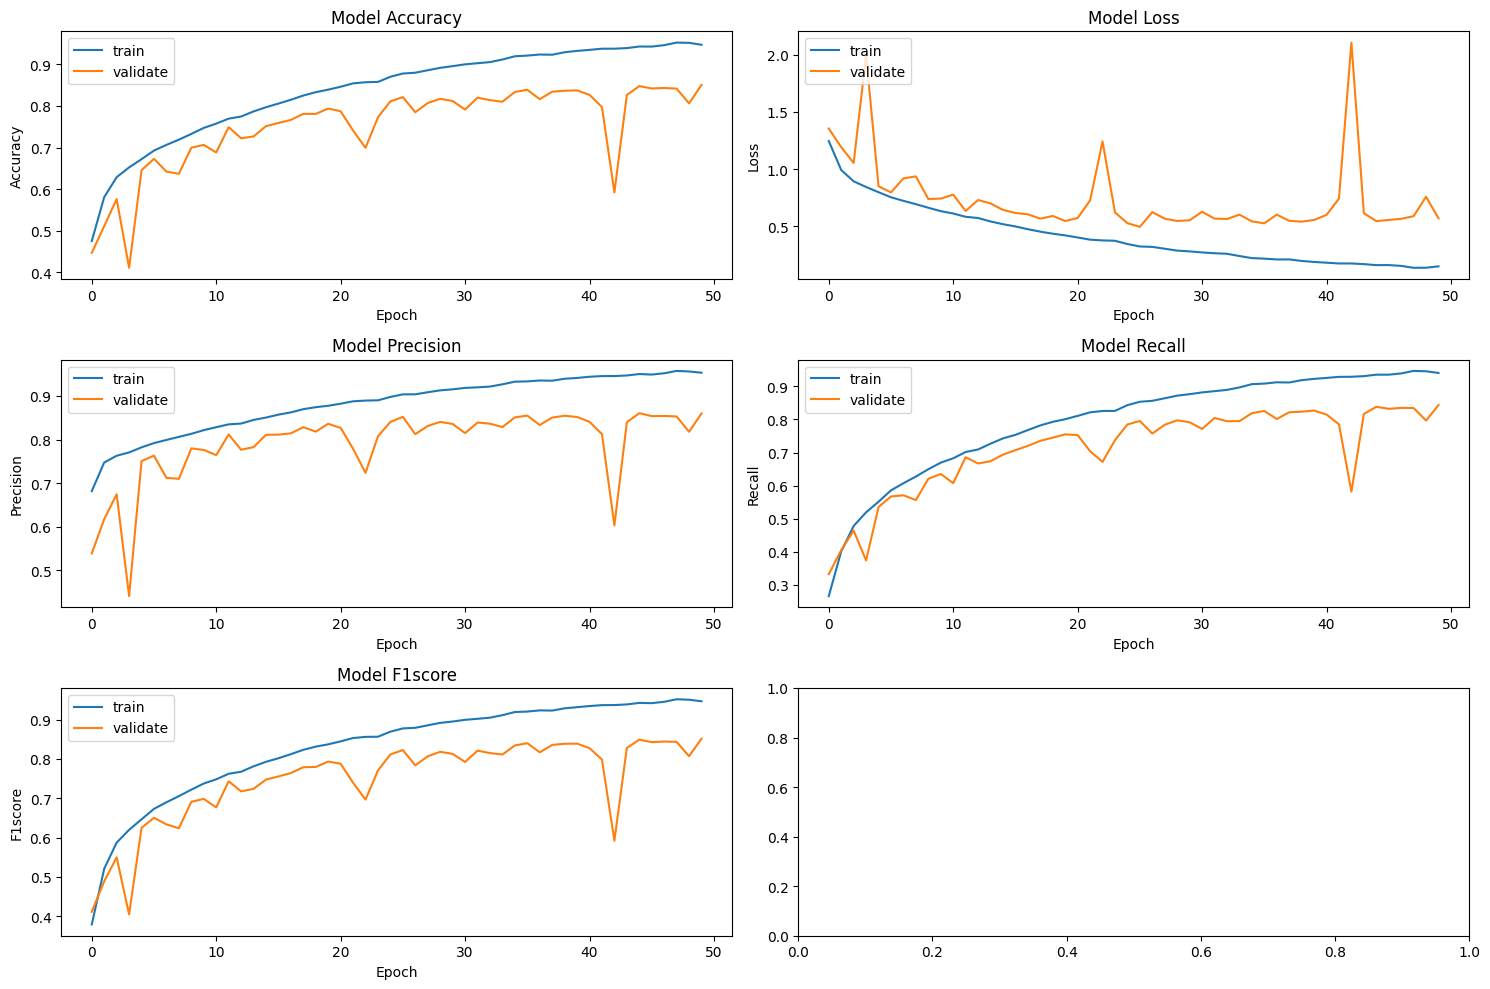

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  3.478440284729004
Accuracy of test set is:  0.44955429434776306
F1score of test set is:  0.44568008184432983
Precision of test set is:  0.45430871844291687
Recall of test set is:  0.4379674196243286


### Draw confusion matrix

In [16]:
label

array(['left middle', 'left ring', 'left thumb', 'left little',
       'left index'], dtype='<U11')

In [17]:
labels = list(label)
labels

['left middle', 'left ring', 'left thumb', 'left little', 'left index']

4473/4473 [==============================] - 22s 5ms/step


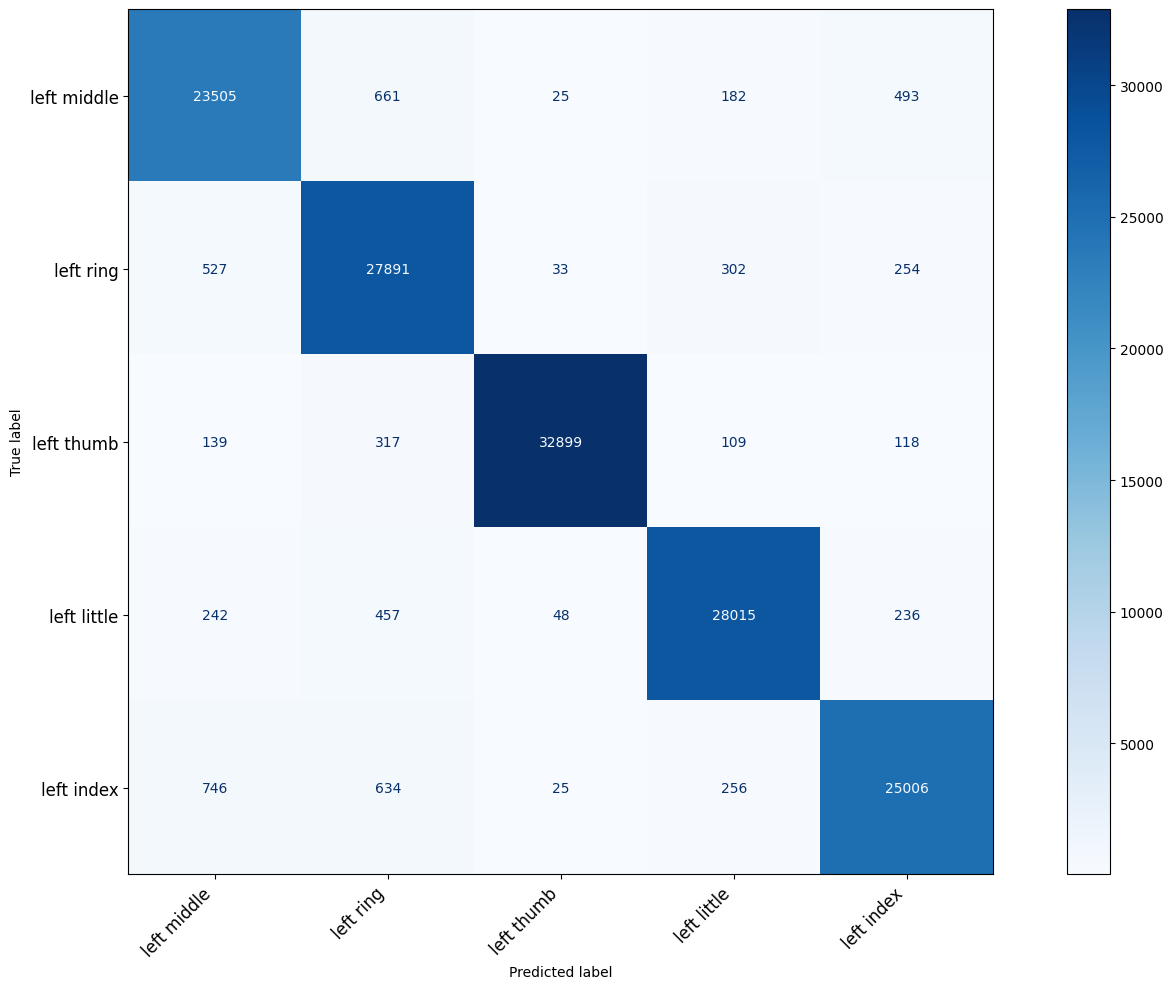

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((143120, 32, 32, 1), (143120, 5), (42967, 32, 32, 1), (42967, 5))

1343/1343 [==============================] - 6s 5ms/step


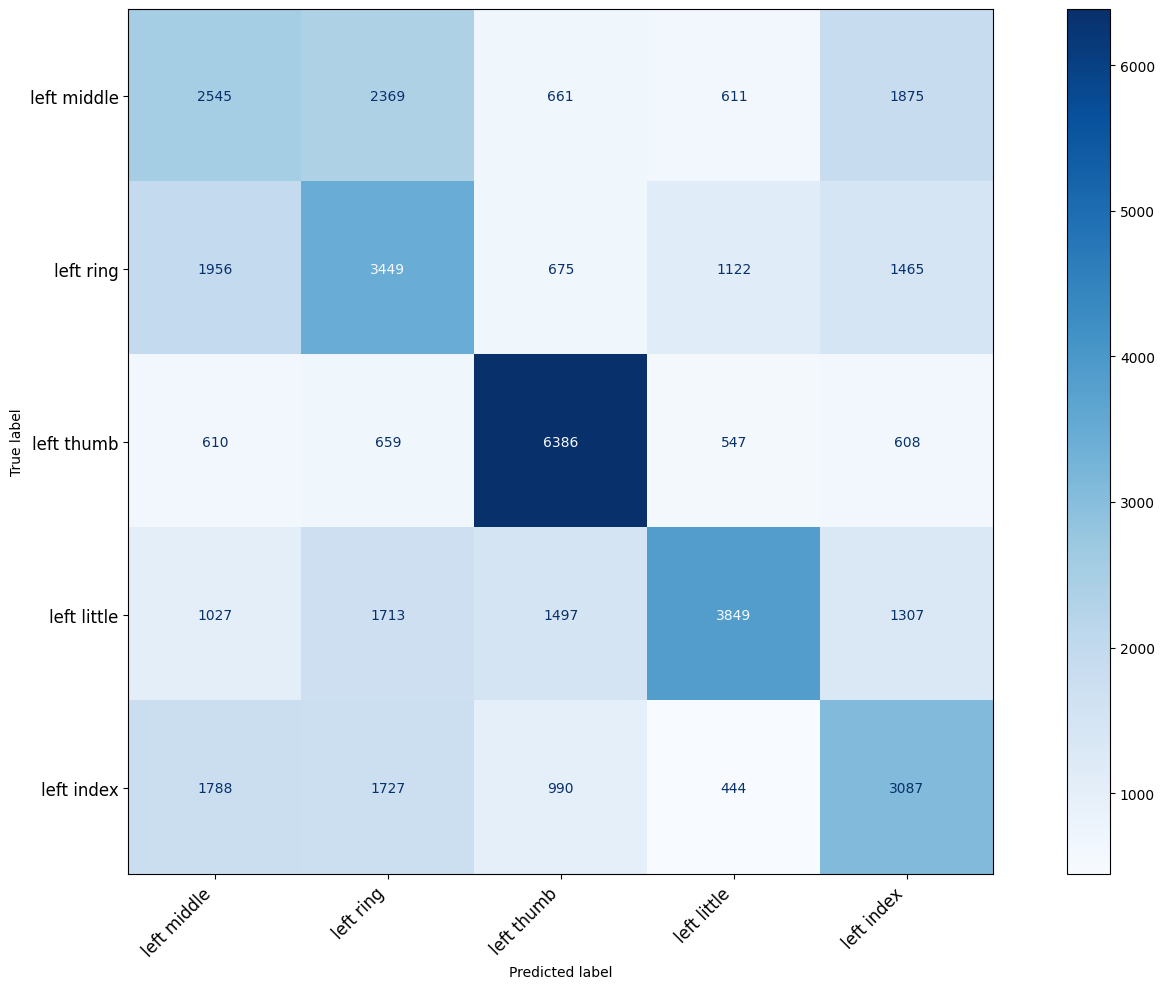

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
